# Generalized Lasso examples

Minimization problem of Generalized Lasso can be described as follows.

$$
\min_{\beta, \gamma}\left\{ \frac{1}{2n}\| y - X\beta \|_2^2 + \lambda \|\gamma\|_1 \right\} \ \ \ \text{subject to} \ \ \  D\beta = \gamma
$$


By choosing proper matrix $D$, you can easily run several algorithms like

* fused Lasso
* cluster Lasso
* trend filtering

fused Lasso is shown in this example.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 1

# add parent directory to load spmimage
import sys
sys.path.append('..')

In [2]:
def show_plot(coef, value, coef_expected = None, value_expected = None, suptitle=None):
    # Plot signal and result
    
    plt.figure(figsize=(16,4))
    plt.subplot(1,2,1)
    plt.plot(coef, label='original')
    if coef_expected is not None:
        plt.plot(coef_expected, label='expected')    
    plt.title('coeficients')
    plt.legend(loc=1)
    plt.grid()

    plt.subplot(1,2,2)
    plt.plot(value, label='original')
    if value_expected is not None:
        plt.plot(value_expected, label='expected')        
    
    plt.title('value')
    plt.legend(loc=1)
    plt.grid()
    
    if suptitle is not None:
        plt.suptitle(suptitle)    

    plt.tight_layout()    
    if suptitle is not None:
        plt.subplots_adjust(top=0.85)

In [3]:
# fix the seed of random
np.random.seed(0)

## Fused Lasso

Fused Lasso minimises the following objective function.

$$
\frac{1}{2n}\| y - X\beta \|_2^2 + \lambda_1 \sum_{j=1}^p\left|\beta_j\right| + \lambda_2 \sum_{j=2}^p\left|\beta_j - \beta_{j-1}\right|
$$

where $\lambda_1$ tunes sparcity in $\beta$ and $\lambda_2$ does fusibility. In Generalized Lasso form, $D$ will be

$$
D = \frac{1}{\lambda} \left( \lambda_1I_p + \lambda_2 \left(\begin{array}{cccccc}
0 & 0 & 0 & \ldots & 0 & 0 \\
-1 & 1 & 0 & \ldots & 0 & 0 \\
0 & -1 & 1 & \ldots & 0 & 0 \\
\ & \vdots & \  & \ddots & \  & \vdots \\
0 & 0 & 0 & -1 & 1 & 0 \\
0 & 0 & 0 & \ldots & -1 & 1
\end{array}
\right)
\right) 
$$

In [4]:
from spmimage.linear_model.admm import GeneralizedLasso

class FusedLasso(GeneralizedLasso):
    
    def __init__(self, sparse_coef=0.0, fused_coef=0.1, rho=1.0, fit_intercept=True,
                 normalize=False, copy_X=True, max_iter=1000,
                 tol=1e-4):
        super().__init__(alpha=1.0, rho=rho, fit_intercept=fit_intercept,
                         normalize=normalize, copy_X=copy_X, max_iter=max_iter,
                         tol=tol)
        self.sparse_coef = sparse_coef
        self.fused_coef = fused_coef
        
    def generate_transform_matrix(self, n_features):
        fused = np.eye(n_features) - np.eye(n_features, k=-1)
        fused[0, 0] = 0
        return self.sparse_coef * np.eye(n_features) + self.fused_coef * fused    

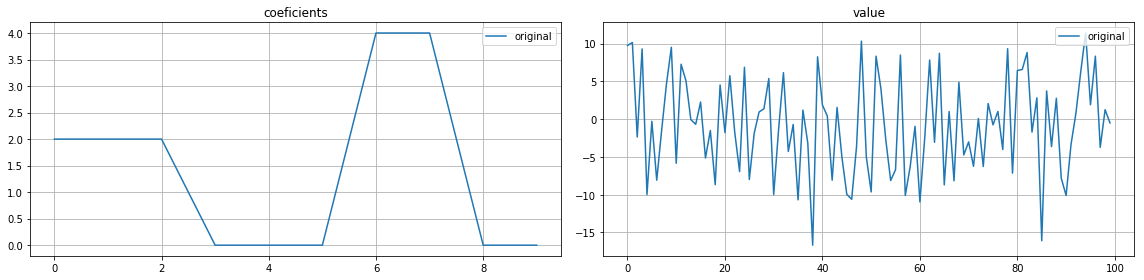

In [5]:
# input signals

n_samples = 100
n_features = 10
beta = np.zeros(n_features)
beta[0:3] = 2
beta[6:8] = 4

X = np.random.normal(0.0, 1.0, (n_samples, n_features))
y = X.dot(beta) + np.random.normal(0, 0.5)
show_plot(beta, y)

In [6]:
def run_fused_lasso(l1, l2):

    clf = FusedLasso(sparse_coef=l1, fused_coef=l2, tol=1e-8)
    clf.fit(X, y)
    
    glasso_signal = clf.coef_
    glasso_predict = X.dot(glasso_signal)    
    
    # Plot signal and result
    show_plot(beta, y, glasso_signal, glasso_predict, 'L1={0} and L2={1}'.format(l1, l2))
    return np.linalg.norm(y - glasso_predict), glasso_signal

45.01690317832502
[ 0.56478059  0.56478059  0.56478059 -1.33688789 -1.33688789 -1.33688789
  2.4997516   2.4997516  -1.34159064 -1.34159064]
CPU times: user 197 ms, sys: 8.39 ms, total: 206 ms
Wall time: 215 ms


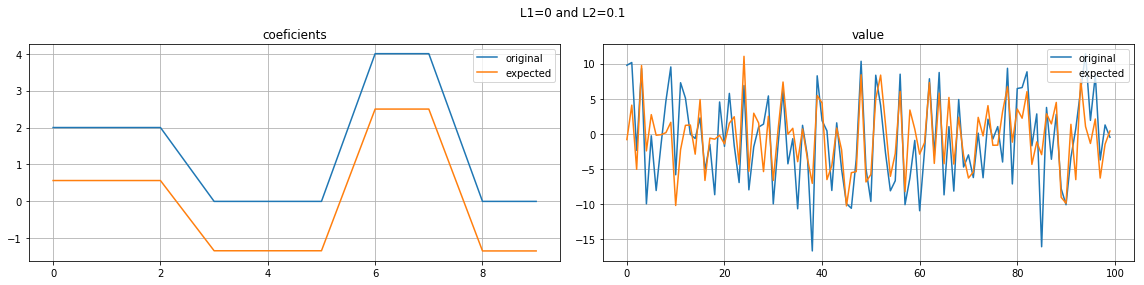

In [7]:
%%time

error, coef = run_fused_lasso(0, 0.1)
print(error)
print(coef)

6.230896177080011
[2.06112073 1.84268581 1.59163802 0.17882565 0.08941283 0.04470641
 3.79755116 3.74689513 0.1709958  0.0854979 ]
CPU times: user 160 ms, sys: 10.3 ms, total: 170 ms
Wall time: 168 ms


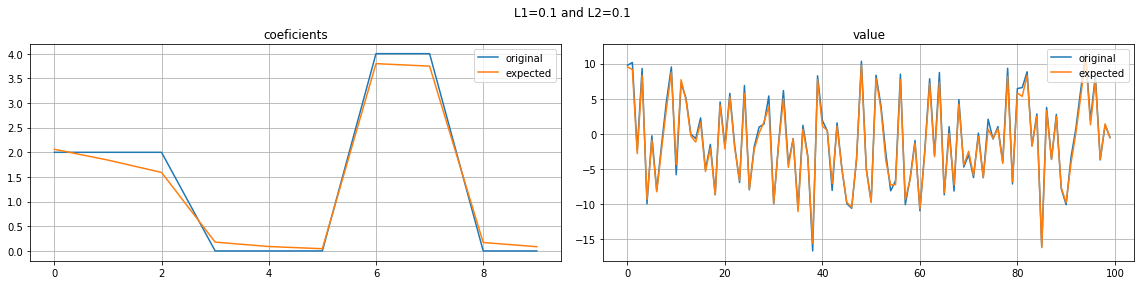

In [8]:
%%time

error, coef = run_fused_lasso(0.1, 0.1)
print(error)
print(coef)

3.353537266152601
[1.91836325 1.89924816 1.86324649 0.         0.         0.
 3.87457234 3.90734386 0.         0.        ]
CPU times: user 193 ms, sys: 10.3 ms, total: 203 ms
Wall time: 200 ms


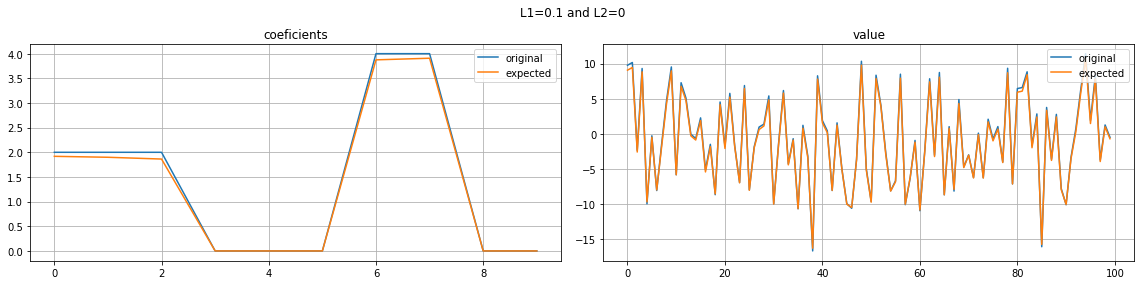

In [9]:
%%time

error, coef = run_fused_lasso(0.1, 0)
print(error)
print(coef)